# [Kaggle] Bike Sharing Demand

대회 링크: [Bike Sharing Demand - Forecast use of a city bikeshare system](https://www.kaggle.com/competitions/bike-sharing-demand/data)

참고
* 감자 님의 [[Kaggle] Bike Sharing Demand : 자전거 수요 예측](https://didu-story.tistory.com/43?category=937100)
* plaette 님의 [랜덤 포레스트 원리와 구현 사이킷런 예제로 코드 실습해보기](https://for-my-wealthy-life.tistory.com/15)
* _lambda 님의 [랜덤포레스트 (Random Forest)](https://data-workspace.tistory.com/35)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. 데이터 확인

In [2]:
train = pd.read_csv('data/bike-sharing-demand/train.csv')
test = pd.read_csv('data/bike-sharing-demand/test.csv')
submission = pd.read_csv('data/bike-sharing-demand/sampleSubmission.csv')

In [3]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [4]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

대회 설명에 따르면 `count` 컬럼을 예측해야 함을 알 수 있다.
> You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

cf. `count` = `casual` + `registered`

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


`submission` 예시를 보니 `test` 데이터의 `datetime` 과 이에 대응되는 예측한 `count` 값을 함께 담아 제출하면 되겠다. 즉, 이 문제는 회귀 문제이다. 우선은 데이터의 특성과 상관 없이 `RandomForestRegressor` 를 사용하는 연습을 해 보기로 한다.

In [8]:
from sklearn.ensemble import RandomForestRegressor

## 2. 데이터 전처리

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


pandas 의 함수를 이용해 `datetime` 컬럼의 데이터형을 `datetime64` 로 바꿔준다.

In [11]:
train.datetime = pd.to_datetime(train.datetime)
test.datetime = pd.to_datetime(test.datetime)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [14]:
print(train.shape, test.shape)

(10886, 12) (6493, 9)


### 2.1. EDA (Exploratory Data Analysis)

EDA 는 '탐색적 데이터 분석'으로 데이터를 분석하기 전 데이터의 특성을 여러 관점에서 살펴보는 일을 말한다.

In [15]:
train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour
train['minute'] = train.datetime.dt.minute
train['second'] = train.datetime.dt.second
train['dayofweek'] = train.datetime.dt.dayofweek

test['year'] = test.datetime.dt.year
test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour
test['minute'] = test.datetime.dt.minute
test['second'] = test.datetime.dt.second
test['dayofweek'] = test.datetime.dt.dayofweek

우선 위와 같이 편리한 분석을 위해 `datetime` 자료형을 쪼개어 새 컬럼들을 만들어준다.

이어서 각 변수 컬럼들과 예측해야 할 자전거의 수요 `count` 값과의 관계를 시각화해서 살펴본다.

<AxesSubplot:xlabel='year', ylabel='count'>

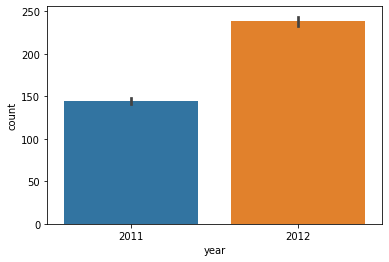

In [16]:
sns.barplot(data=train, x='year', y='count')

<AxesSubplot:xlabel='month', ylabel='count'>

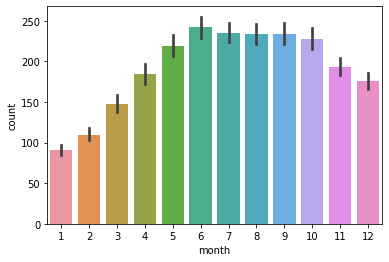

In [17]:
sns.barplot(data=train, x='month', y='count')

<AxesSubplot:xlabel='day', ylabel='count'>

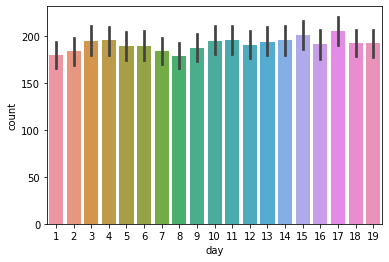

In [18]:
sns.barplot(data=train, x='day', y='count')

<AxesSubplot:xlabel='season', ylabel='count'>

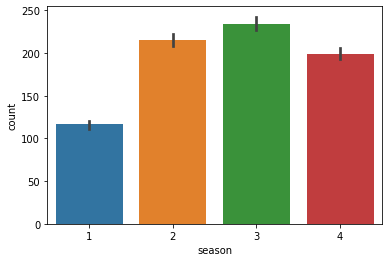

In [19]:
sns.barplot(data=train, x='season', y='count')

<AxesSubplot:xlabel='season', ylabel='count'>

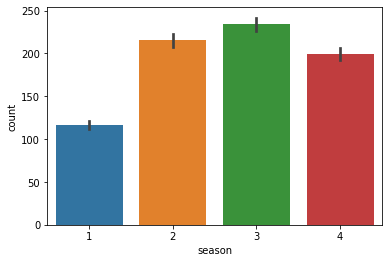

In [20]:
sns.barplot(data=train, x='season', y='count')

In [21]:
print(train[train.season == 1].month.unique())
print(train[train.season == 2].month.unique())
print(train[train.season == 3].month.unique())
print(train[train.season == 4].month.unique())

[1 2 3]
[4 5 6]
[7 8 9]
[10 11 12]


위와 같이 `dataframe` 에 대괄호로 조건문을 걸어서 원하는 값만을 뽑아낼 수 있다. `season` 컬럼의 데이터의 의미 (어떤 달로 나누어저 있는지) 를 알 수 있다.

<AxesSubplot:xlabel='hour', ylabel='count'>

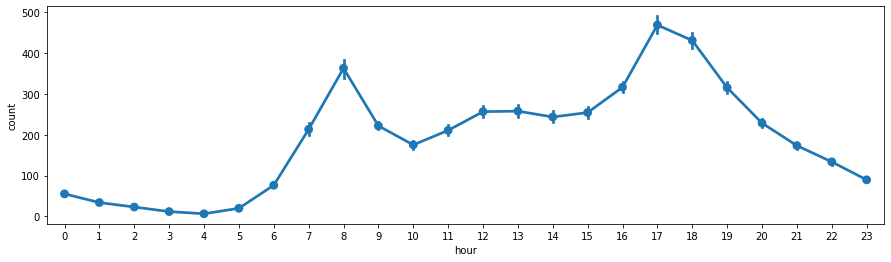

In [22]:
plt.figure(figsize=(15,4))
sns.pointplot(data=train, x='hour', y='count')

`workingday`, `holiday`, `weather`, `dayofweek` 컬럼은 시간을 바탕으로 카테고리를 분류하여 분석해본다.

<AxesSubplot:xlabel='hour', ylabel='count'>

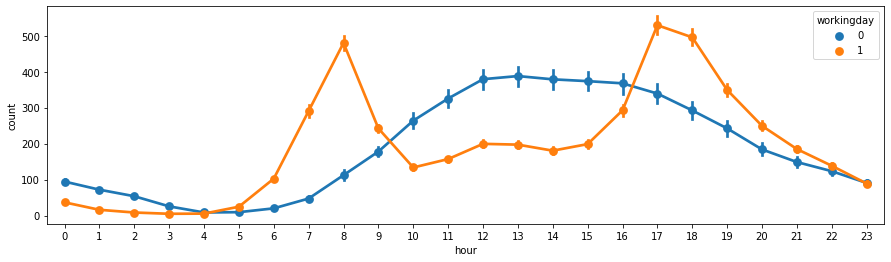

In [23]:
plt.figure(figsize=(15,4))
sns.pointplot(data=train, x='hour', y='count', hue='workingday')

위와 같이 `hue` 변수를 주어 카테고리별로 묶어서 그래프를 그릴 수 있다.

<AxesSubplot:xlabel='hour', ylabel='count'>

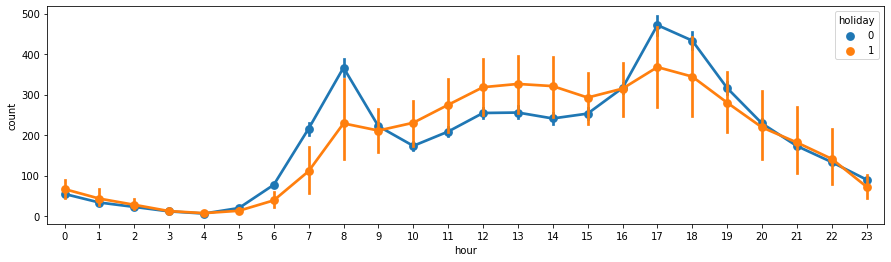

In [24]:
plt.figure(figsize=(15,4))
sns.pointplot(data=train, x='hour', y='count', hue='holiday')

<AxesSubplot:xlabel='hour', ylabel='count'>

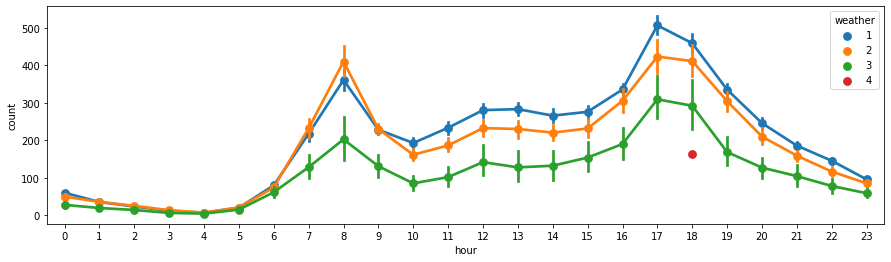

In [25]:
plt.figure(figsize=(15,4))
sns.pointplot(data=train, x='hour', y='count', hue='weather')

> weather
> 
> 1: Clear, Few clouds, Partly cloudy, Partly cloudy
> 
> 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
>
> 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
> 
> 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

<AxesSubplot:xlabel='hour', ylabel='count'>

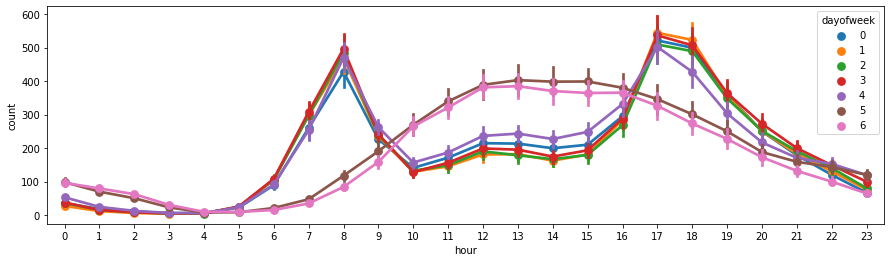

In [26]:
plt.figure(figsize=(15,4))
sns.pointplot(data=train, x='hour', y='count', hue='dayofweek')

<AxesSubplot:>

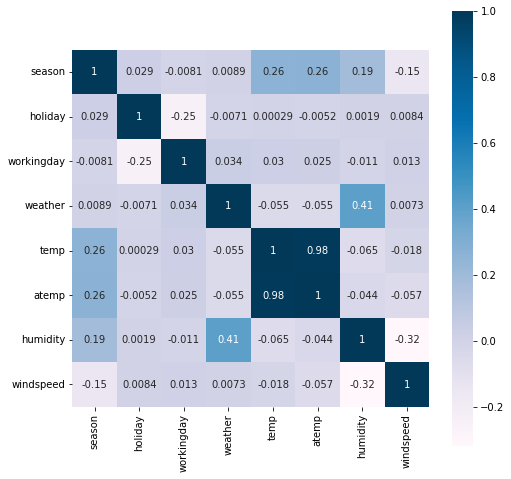

In [27]:
plt.figure(figsize=(8, 8))
correlation_data = train[['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed']]
sns.heatmap(
    correlation_data.corr(),
    square=True,
    annot=True,
    cmap='PuBu',
)

일반적으로 회귀 분석에서는 변수들이 서로 독립이라고 가정해야 한다. 그러나 위에서 `temp` 와 `atemp` 컬럼은 서로 상관관계가 높으므로 다중공산성 (multicollinearity) 이 의심된다. 따라서 이 중 하나를 제외하고 모델을 학습시키도록 한다.

이어서 연속형 자료들을 시각화해본다. (`temp`, `humidity`, `windspeed`)

<AxesSubplot:xlabel='windspeed', ylabel='count'>

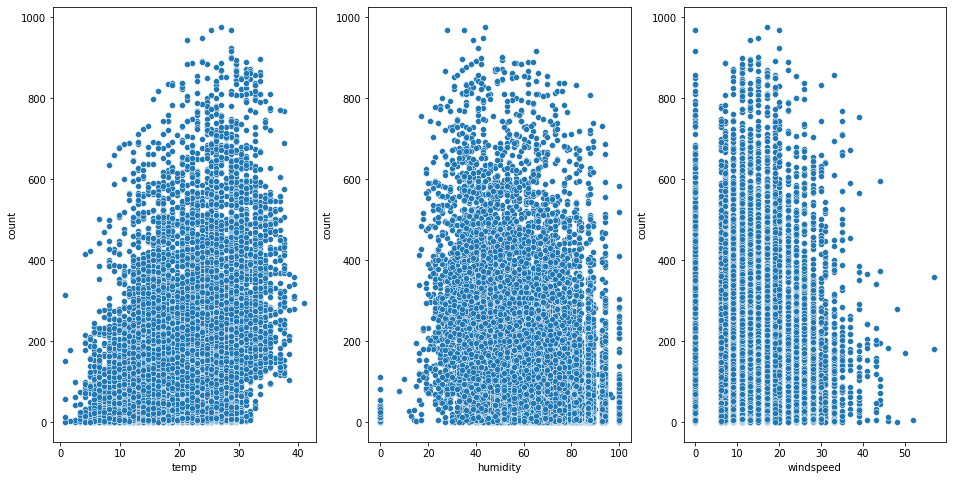

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))
sns.scatterplot(data=train, x='temp', y='count', ax=ax1)
sns.scatterplot(data=train, x='humidity', y='count', ax=ax2)
sns.scatterplot(data=train, x='windspeed', y='count', ax=ax3)

왜 scatterplot 으로 그려야 할까?

<AxesSubplot:xlabel='windspeed', ylabel='count'>

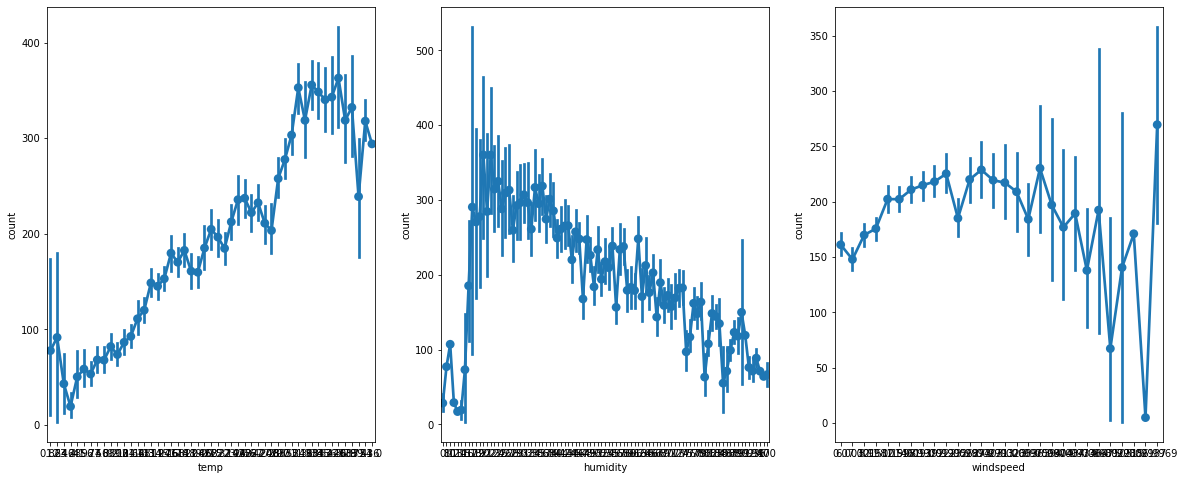

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 8))
sns.pointplot(data=train, x='temp', y='count', ax=ax1)
sns.pointplot(data=train, x='humidity', y='count', ax=ax2)
sns.pointplot(data=train, x='windspeed', y='count', ax=ax3)

애초에 pointplot 이 scatterplot 을 이용해 estimate 와 confidence interval 을 보여주므로 특히 자료가 연속형일 때는 scatterplot 을 쓰는 것이 시각화 했을 때 더 정보가 많이 보여서 그런 게 아닐까

In [30]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek'],
      dtype='object')

카테고리형: `'datetime', 'season', 'holiday', 'workingday', 'weather'`

연속형: `'temp', 'atemp', 'humidity', 'windspeed'` (변수), `'casual', 'registered', 'count'` (예측)

### 2.2. Feature Engineering

피쳐 엔지니어링은 데이터의 도메인 지식을 활용해 머신러닝 모델이 잘 동작하도록 하는 피쳐를 만드는 작업이다. 일부는 확인만 해 보고 진행하지 않았다.

#### 2.2.1. Outlier

연속형 컬럼에 대한 boxplot 을 그려 outlier 를 확인한다.

<AxesSubplot:xlabel='count'>

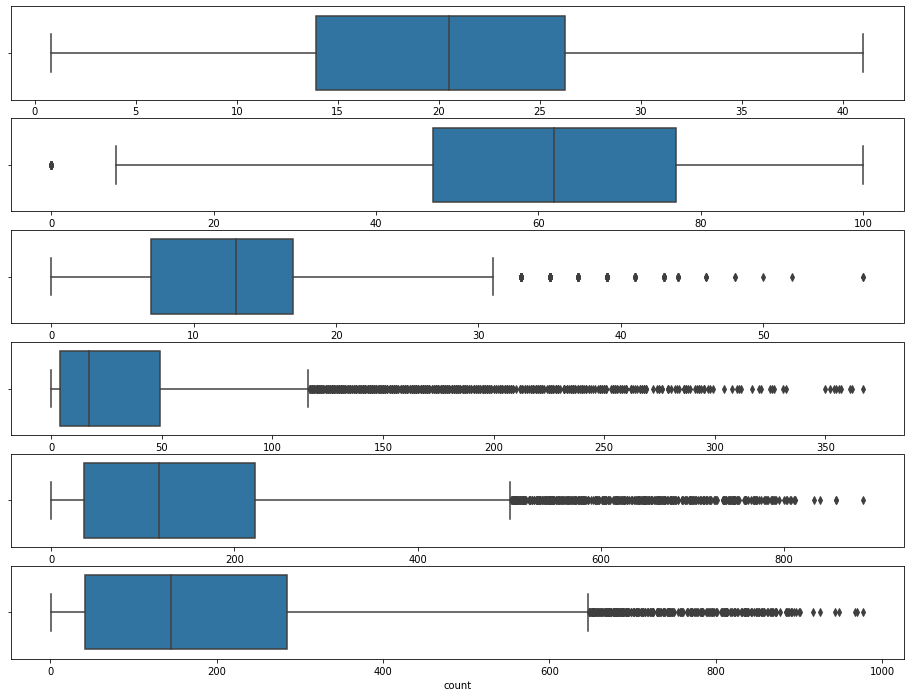

In [31]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, figsize=(16, 12))
sns.boxplot(data=train, x='temp', ax=ax1)
sns.boxplot(data=train, x='humidity', ax=ax2)
sns.boxplot(data=train, x='windspeed', ax=ax3)
sns.boxplot(data=train, x='casual', ax=ax4)
sns.boxplot(data=train, x='registered', ax=ax5)
sns.boxplot(data=train, x='count', ax=ax6)

#### 2.2.2. Skewness and Kurtosis

##### Skewness (왜도)
 
* [-2, 2] 정도여야 치우침이 없는 데이터라고 함

##### Kurtosis (첨도)

* Kurtosis 가 높으면 outlier 가 많다

skewness: 1.2420662117180776
kurtosis: 1.3000929518398334


/Users/elpion/miniconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


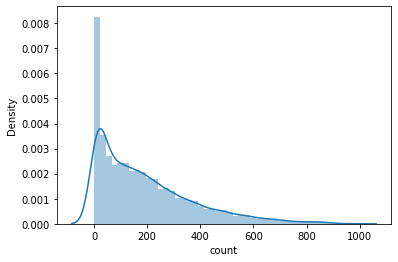

In [32]:
sns.distplot(train['count'])
print('skewness:', train['count'].skew())
print('kurtosis:', train['count'].kurt())

#### 2.2.3. One-hot Encoding

In [33]:
train = pd.get_dummies(train, columns=['weather'], prefix=['weather'])
test = pd.get_dummies(test, columns=['weather'], prefix=['weather'])
train = pd.get_dummies(train, columns=['season'], prefix=['season'])
test = pd.get_dummies(test, columns=['season'], prefix=['season'])
train = pd.get_dummies(train, columns=['holiday'], prefix=['holiday'])
test = pd.get_dummies(test, columns=['holiday'], prefix=['holiday'])

In [34]:
train.columns

Index(['datetime', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'casual', 'registered', 'count', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'dayofweek', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'season_1', 'season_2', 'season_3', 'season_4',
       'holiday_0', 'holiday_1'],
      dtype='object')

In [35]:
test.columns

Index(['datetime', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'season_1',
       'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1'],
      dtype='object')

## 3. 학습 데이터 준비

### 3.1. Data Drop

In [36]:
test_datetime = test['datetime']

train.drop(['datetime', 'workingday', 'atemp', 'windspeed', 'casual', 'registered', 'minute', 'second', 'dayofweek'], axis=1, inplace=True)
test.drop(['datetime', 'workingday', 'atemp', 'windspeed', 'minute', 'second', 'dayofweek'], axis=1, inplace=True)

In [37]:
train.columns

Index(['temp', 'humidity', 'count', 'year', 'month', 'day', 'hour',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'season_1',
       'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1'],
      dtype='object')

In [38]:
test.columns

Index(['temp', 'humidity', 'year', 'month', 'day', 'hour', 'weather_1',
       'weather_2', 'weather_3', 'weather_4', 'season_1', 'season_2',
       'season_3', 'season_4', 'holiday_0', 'holiday_1'],
      dtype='object')

### 3.1. 데이터셋 분할

In [39]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [40]:
x_train = train.drop('count', axis=1).values  # array
target_label = train['count'].values
x_test = test.values

In [41]:
x_train, x_val, y_train, y_val = train_test_split(x_train, target_label, test_size=0.2)

In [42]:
x_train

array([[2.296e+01, 7.300e+01, 2.012e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.624e+01, 6.900e+01, 2.011e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.624e+01, 8.900e+01, 2.011e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [2.870e+01, 8.900e+01, 2.011e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.050e+01, 2.500e+01, 2.012e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.640e+01, 9.400e+01, 2.012e+03, ..., 1.000e+00, 1.000e+00,
        0.000e+00]])

In [43]:
x_val

array([[1.640e+01, 9.400e+01, 2.011e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.722e+01, 9.400e+01, 2.012e+03, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.640e+01, 8.200e+01, 2.011e+03, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [2.706e+01, 8.900e+01, 2.011e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [3.772e+01, 2.900e+01, 2.012e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [8.200e+00, 4.700e+01, 2.011e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [44]:
y_train

array([ 40,  94,  96, ...,  13, 299, 302])

In [45]:
y_val

array([ 28, 200,  91, ...,  21, 770,  45])

## 4. 학습

In [46]:
model = RandomForestRegressor(max_depth=5, verbose=1)
model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestRegressor(max_depth=5, verbose=1)

In [47]:
y_pred = model.predict(x_val)
y_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([ 56.95156039, 274.96917144, 107.9738989 , ...,  19.08354519,
       518.28397872, 103.1008389 ])

In [48]:
model.score(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.6636092002570455

In [49]:
model.score(x_val, y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.6526060552391315

In [50]:
feature_importance = model.feature_importances_

/Users/elpion/miniconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

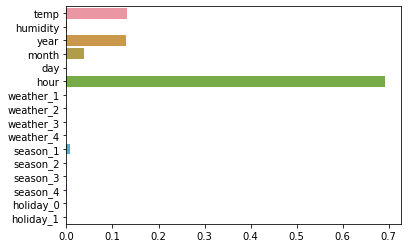

In [51]:
sns.barplot(feature_importance, train.drop('count', axis=1).columns)